In [1]:
import pandas
import matplotlib.pyplot as plt
import numpy as np
data = pandas.read_csv('./integrals_with_metadata.txt',sep='\t')

In [2]:
data

,experiment_id,Harvest.Date,Run,Plate,Column,Row,species,normalized_OD,qpcr_4plex_Cy5.356.,qpcr_3plex_TR.360.,...,Hypoxanthine,unknown32,Adenine,unknown33,unknown34,unknown35,Formate,AMP,Nicotinate,Nicotinamide
0,164A,1/10/2017,1,6,4,A,"492,502",0.098167,NaN,NaN,...,0.014135,0.010405,0.064860,0.005110,0.006684,0.002684,0.013534,0.001123,0.007057,0.002967
1,224A,1/11/2017,2,2,4,A,"356,360",0.186158,3.624363,0.062894,...,0.033622,0.009804,0.031086,0.007056,0.017199,0.003422,0.019196,0.006320,0.009158,0.002559
2,273A,1/11/2017,2,7,3,A,"500,519",0.286358,0.000007,NaN,...,0.005929,0.011126,0.034464,0.007023,0.005531,0.003170,0.114830,0.001461,0.006193,0.005391
3,233A,1/11/2017,2,3,3,A,"356,500",0.183658,2.778331,NaN,...,0.034011,0.017737,0.011228,0.015492,0.009334,0.004416,0.021951,0.000931,0.008769,0.002198
4,144A,1/10/2017,1,4,4,A,"360,500",0.012067,NaN,1.163136,...,0.009275,0.009466,0.051925,0.006083,0.015608,0.002938,0.020428,0.008249,0.008088,0.002727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279,381A,1/12/2017,3,8,1,A,0,0.005742,0.000018,NaN,...,0.007769,0.010287,0.012393,0.015175,0.010212,0.003860,0.024337,0.002428,0.003834,0.007004
280,111C,1/10/2017,1,1,1,C,356,0.186067,1.225792,NaN,...,0.034442,0.016565,0.011135,0.014990,0.009372,0.004724,0.019559,0.002801,0.008765,0.002081
281,131C,1/10/2017,1,3,1,C,"356,361",0.050467,0.272093,NaN,...,0.011056,0.010123,0.047652,0.014877,0.009637,0.004741,0.091361,0.003768,0.009443,0.001845
282,363C,1/12/2017,3,6,3,C,"492,500",0.018592,NaN,NaN,...,0.007864,0.012127,0.015643,0.013049,0.009235,0.003265,0.023208,0.000907,0.003771,0.005322


In [3]:
# dictionary of protons per compound in dissociated form;
# reference is TSP, which has 9 protons that generate the 
# peak at 0.0ppm (3 CH3 groups).

# Below are the peaks that were integrated in the original study:
# butyrate - triplet from CH3 at ~.99ppm
# acetate - singlet from CH3 at 1.9ppm
# propionate - triplet from CH3 at ~1.04ppm
# formate - singlet from 1 H at 8.44ppm
# isovalerate - doublet at ~0.91 from 6 hydrogens
# lactate - doublet from 3 hydrogens on CH3 at ~1.3ppm

protons = {'Acetate':3.0,
           'Formate':1.0,
           'Propionate':3.0,
           'Isovalerate':6.0,
           'Butyrate':3.0,
           'Lactate':3.0}

# M/S = IM/IS * NS/NM
# M = unknown concentration of the metabolite
# S = known concentration of the internal standard
# IM + IS = Integrals of the metabolite and standard, respectively
# NM + NS = Number of protons on the metabolite and standard, respectively
# M = S*(IM/IS * NS/NM)
ratios = {key:9.0/protons[key] for key,value in protons.items()}
#S, concentration of TSP
# concentration was 0.1% g/g, so 1g/L of TSP in the buffer
# 60uL of buffer was added to 540uL sample, so buffer was 10% of final solutions
tsp_na_salt_concentration = 0.1*1/172.27 # 10% * 1g/L / 172.27g/mol = mol/L
# All samples were standardized to an integral of 1 for the TSP peak

In [4]:
# load the raw spectra to get the area of TSP
tsp_na_salt_concentration

0.0005804841237592152

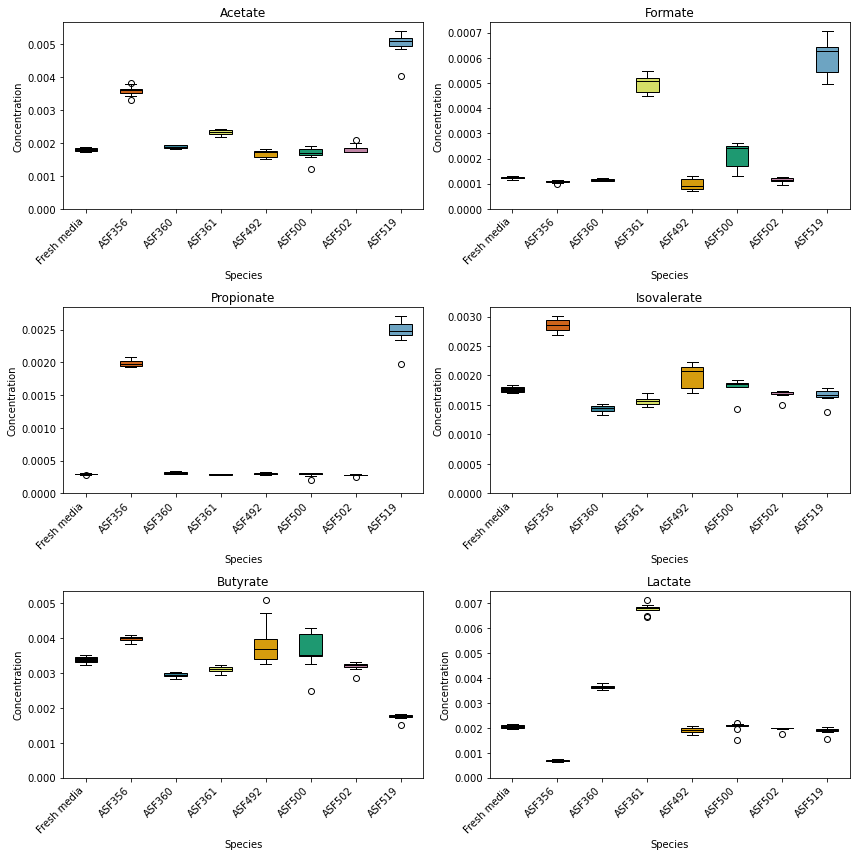

In [5]:
fig,axes = plt.subplots(3,2)
axes = np.ravel(axes)
species = ['0','356','360','361','492','500','502','519']
species_colormap = []
names = ["ASF"+x for x in species]
names[0] = "Fresh media"
# get only the monoculture samples, then sort by species for ordering in plots
monoculture_subset = data.loc[data['species'].isin(species)].sort_values('species')

bplots = []
metabolite_count = 0
for metabolite in protons.keys():
    concentration = tsp_na_salt_concentration*(monoculture_subset[metabolite] * ratios[metabolite])
    monoculture_subset[metabolite+'_abs_conc'] = concentration
    # generate a boxplot with a panel for each metabolite
    metabolite_df = pandas.pivot_table(monoculture_subset[['species',metabolite+'_abs_conc']],
               values=metabolite+'_abs_conc',
               index='species',
               aggfunc=list)
    metabolite_values = [np.asarray(x[0]) for x in metabolite_df.values]
    metabolite_labels = metabolite_df.index.tolist()
    bplots.append(axes[metabolite_count].boxplot(metabolite_values,labels=metabolite_labels,patch_artist=True,medianprops={'color':'black'}))
    axes[metabolite_count].set_ylim(0,1.05*max([max(x) for x in metabolite_values]))
    axes[metabolite_count].set_ylabel("Concentration")
    axes[metabolite_count].set_xlabel("Species")
    axes[metabolite_count].set_xticklabels(labels=names,rotation=45,ha="right")
    axes[metabolite_count].set_title(metabolite)
    #plot horizontal line with mean value from fresh media
    #axes[metabolite_count].hlines(np.mean(metabolite_df.loc['0'].values[0]))
    metabolite_count+=1
    
colors = [(0,0,0),(205,100,27),(54,131,152),(215,224,103),(215,157,14),(30,154,113),(191,134,166),(109,165,195)]
colors = [(a/256,b/256,c/256) for (a,b,c) in colors]

for bplot in bplots:
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)        
        
fig.set_size_inches(12,12)
fig.tight_layout()
plt.savefig('./scfa_quantities.svg')
plt.savefig('./scfa_quantities.png')

plt.show()

In [7]:
monoculture_subset

,experiment_id,Harvest.Date,Run,Plate,Column,Row,species,normalized_OD,qpcr_4plex_Cy5.356.,qpcr_3plex_TR.360.,...,Formate,AMP,Nicotinate,Nicotinamide,Acetate_abs_conc,Formate_abs_conc,Propionate_abs_conc,Isovalerate_abs_conc,Butyrate_abs_conc,Lactate_abs_conc
134,181B,1/10/2017,1,8,1,B,0,0.000600,1.720960e-08,NaN,...,0.024768,0.002241,0.003673,0.007609,0.001846,0.000129,0.000296,0.001814,0.003466,0.002107
95,423B,12/16/2016,4,2,3,B,0,0.002642,NaN,NaN,...,0.024216,0.001978,0.004768,0.007409,0.001726,0.000127,0.000278,0.001712,0.003258,0.001980
136,281B,1/11/2017,2,8,1,B,0,0.003867,NaN,NaN,...,0.023937,0.001880,0.004054,0.008309,0.001870,0.000125,0.000301,0.001837,0.003489,0.002148
167,423A,12/16/2016,4,2,3,A,0,0.003642,NaN,NaN,...,0.023222,0.001857,0.003605,0.007118,0.001758,0.000121,0.000295,0.001733,0.003312,0.001993
25,281A,1/11/2017,2,8,1,A,0,0.004267,NaN,NaN,...,0.022205,0.001165,0.003613,0.007366,0.001868,0.000116,0.000303,0.001846,0.003499,0.002151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,123B,1/10/2017,1,2,3,B,519,0.231967,7.448230e-05,NaN,...,0.094604,0.000575,0.003625,0.005678,0.004048,0.000494,0.001980,0.001377,0.001496,0.001554
237,223C,1/11/2017,2,2,3,C,519,0.264158,NaN,0.000132,...,0.134980,0.001048,0.003714,0.006668,0.005306,0.000705,0.002499,0.001685,0.001821,0.002027
218,323C,1/12/2017,3,2,3,C,519,0.251992,NaN,0.000053,...,0.120150,0.000745,0.001804,0.006782,0.005109,0.000628,0.002420,0.001645,0.001735,0.001923
122,223B,1/11/2017,2,2,3,B,519,0.262458,NaN,NaN,...,0.127260,0.000996,0.003399,0.007697,0.005202,0.000665,0.002543,0.001708,0.001830,0.001969
